# Chapter 17
## Image classification

In [1]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from skimage.io import imread
from skimage.transform import resize
from skimage import filters, restoration, util, measure
from skimage.morphology import disk
from sklearn.datasets import fetch_olivetti_faces, fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import decomposition
from collections import Counter

warnings.filterwarnings('ignore')

In [2]:
def show_image(image, cmap=cm.gray):
    plt.imshow(image, cmap=cmap)
    plt.axis('off')
    plt.show()

### Image smoothing

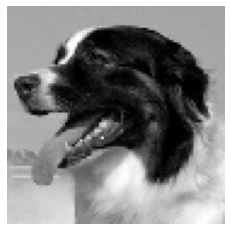

In [3]:
example_file = "https://upload.wikimedia.org/wikipedia/commons/7/7d/Dog_face.png"
image = imread(example_file, as_gray=True)
show_image(image)

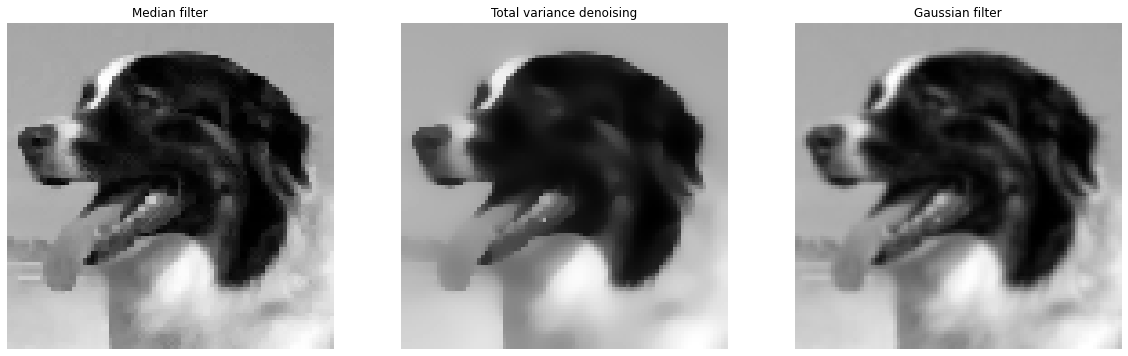

In [4]:
conv_image = util.img_as_ubyte(image)
median_filter = filters.rank.median(conv_image, disk(1))
tv_filter = restoration.denoise_tv_chambolle(conv_image, weight=0.1)
gaussian_filter = filters.gaussian(conv_image, sigma=0.7)

fig = plt.figure(figsize=(20, 6))
for k, (t, F) in enumerate((('Median filter', median_filter), ('Total variance denoising', tv_filter), ('Gaussian filter', gaussian_filter))):
    f = fig.add_subplot(1, 3, k+1)
    plt.axis('off')
    f.set_title(t)
    plt.imshow(F, cmap=cm.gray)
plt.show()

### Resizing

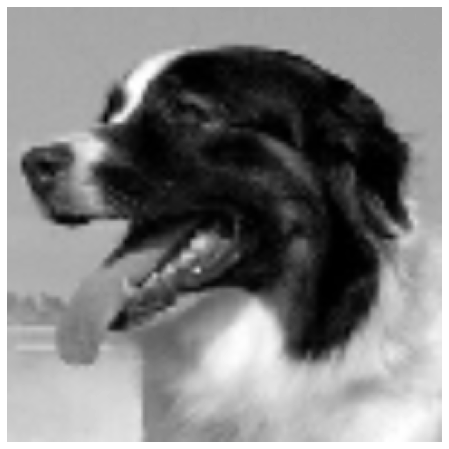

In [5]:
image2 = resize(image, (240, 240), mode='edge', anti_aliasing=True)
plt.figure(figsize=(8, 8))
show_image(image2)

### Border emphasis

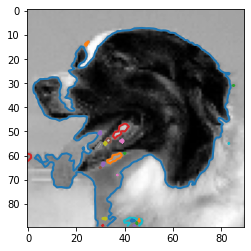

In [6]:
contours = measure.find_contours(image, 0.55)
plt.imshow(image, cmap=cm.gray)

for n, c in enumerate(contours):
    plt.plot(c[:,1], c[:,0], linewidth=2)
plt.axis('image')
plt.show()

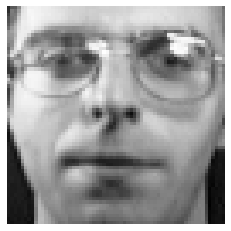

In [7]:
dataset = fetch_olivetti_faces(shuffle=True, random_state=101)
x_train, x_test = dataset.data[:350, :], dataset.data[350:, :]
y_train, y_test = dataset.target[:350], dataset.target[350:]
show_image(x_train[8].reshape(64, 64))

In [8]:
n = 25
pca = PCA(n_components=n, whiten=True, random_state=101).fit(x_train)
print(f"Explained variance by {n} components: {np.sum(pca.explained_variance_ratio_):.3}")

x_train_compressed, x_test_compressed = pca.transform(x_train), pca.transform(x_test)

Explained variance by 25 components: 0.794


Looking for face id: 34


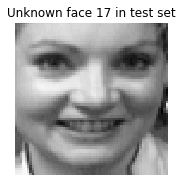

In [9]:
photo = 17
print(f"Looking for face id: {y_test[photo]}")

plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Unknown face ' + str(photo) + ' in test set')
plt.imshow(x_test[photo].reshape(-1, 64), cmap=cm.gray, interpolation='nearest')
plt.show()

In [10]:
mask = x_test_compressed[photo]
squared_errors = np.sum(np.power(x_train_compressed - mask, 2), axis=1)
minimum_error_face = np.argmin(squared_errors)
most_resembling = list(np.where(squared_errors <= 20)[0])
print(f"Best resembling face in train test: {y_train[minimum_error_face]}")

Best resembling face in train test: 34


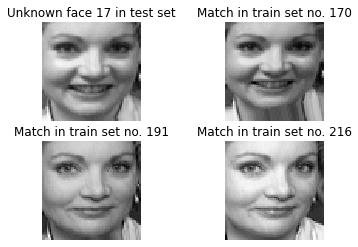

In [11]:
plt.subplot(2, 2, 1)
plt.axis('off')
plt.title('Unknown face ' + str(photo) + ' in test set')
plt.imshow(x_test[photo].reshape(-1, 64), cmap=cm.gray, interpolation='nearest')

for k, m in enumerate(most_resembling):
    plt.subplot(2, 2, 2+k)
    plt.title('Match in train set no. ' + str(m))
    plt.axis('off')
    plt.imshow(x_train[m].reshape(-1, 64), cmap=cm.gray, interpolation='nearest')
plt.show()

### Classification

In [12]:
lfw_people = fetch_lfw_people(min_faces_per_person=60, resize=0.4)
X, y = lfw_people.data, lfw_people.target
target_names = [lfw_people.target_names[a] for a in y]

n_samples, h, w = lfw_people.images.shape
for name, count in Counter(target_names).items():
    print(f"{name} {count}")

Colin Powell 236
George W Bush 530
Hugo Chavez 71
Junichiro Koizumi 60
Tony Blair 144
Ariel Sharon 77
Donald Rumsfeld 121
Gerhard Schroeder 109


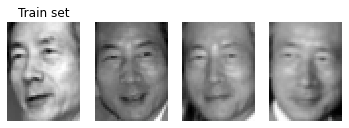

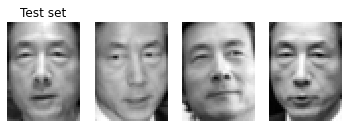

In [13]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=101).split(X, y)
train, test = list(split)[0]

plt.subplot(1, 4, 1)
plt.axis('off')
for k, m in enumerate(X[train][y[train]==6][:4]):
    plt.subplot(1, 4, 1+k)
    if k == 0: plt.title('Train set')
    plt.axis('off')
    plt.imshow(m.reshape(50, 37), cmap=cm.gray, interpolation='nearest')
plt.show()

for k, m in enumerate(X[test][y[test]==6][:4]):
    plt.subplot(1, 4, 1+k)
    if k == 0: plt.title('Test set')
    plt.axis('off')
    plt.imshow(m.reshape(50, 37), cmap=cm.gray, interpolation='nearest')
plt.show()

In [14]:
n = 50
pca = decomposition.PCA(n_components=n, whiten=True, svd_solver='randomized').fit(X[train])
nmf = decomposition.NMF(n_components=n, init='nndsvda', tol=5e-3).fit(X[train])
fastica = decomposition.FastICA(n_components=n, whiten=True).fit(X[train])

eigenfaces = pca.components_.reshape((n, h, w))
X_dec = np.column_stack((pca.transform(X[train]),
                         nmf.transform(X[train]),
                         fastica.transform(X[train])))
Xt_dec = np.column_stack((pca.transform(X[test]),
                         nmf.transform(X[test]),
                         fastica.transform(X[test])))
y_dec, yt_dec = y[train], y[test]

In [15]:
param_grid = {
    'C': np.logspace(-1, 3, 5),
    'gamma': np.logspace(-4, -1, 4)
}
clf = GridSearchCV(SVC(kernel='rbf'), param_grid).fit(X_dec, y_dec)
print(f"Best parameters: {clf.best_params_}")

Best parameters: {'C': 10.0, 'gamma': 0.01}


In [16]:
print(f"Accuracy: {accuracy_score(yt_dec, clf.predict(Xt_dec)):.4}\n")

cm = str(confusion_matrix(yt_dec, clf.predict(Xt_dec)))
print(' '*26 + '  '.join(map(str, range(8))))
print(' '*26 + '-'*22)
for n, (label, row) in enumerate(zip(lfw_people.target_names, cm.split('\n'))):
    print(f"{n} {label:18} -> {row}")

Accuracy: 0.8296

                          0  1  2  3  4  5  6  7
                          ----------------------
0 Ariel Sharon       -> [[ 7  0  0  0  1  0  0  0]
1 Colin Powell       ->  [ 0 22  0  2  0  0  0  0]
2 Donald Rumsfeld    ->  [ 0  0  8  2  1  0  0  1]
3 George W Bush      ->  [ 0  1  3 45  1  1  0  2]
4 Gerhard Schroeder  ->  [ 0  0  1  1  6  1  1  1]
5 Hugo Chavez        ->  [ 0  0  0  0  0  6  0  1]
6 Junichiro Koizumi  ->  [ 0  0  0  0  0  0  6  0]
7 Tony Blair         ->  [ 0  0  0  1  1  0  0 12]]
